# Code for APPM 4360 project
We implement:
* the 1-dimensional comlpex step derivative approximation
* the n-dimensional complex step gradient approximation
* approximate gradient descent using the n-d CSGA
* approximation to $n^{th}$ derivative using theory from Lyness + Moler (ref. in our paper)

and several examples to test the robustness 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import matplotlib as mpl

### Complex step approximation

In [2]:
def complex_step_deriv(func, h = 1e-8):
    # Complex step derivative approx using Taylor expansion
    return(lambda x: np.imag(func(complex(x, h))) / h)

def forward_diff(func, h = 1e-8):
    return (lambda x: (func(x + h) - func(x)) / h)

def central_diff(func, h = 1e-8):
    return (lambda x: (func(x) - func(x - h)) / h)

def backward_diff(func, h = 1e-8):
    return (lambda x: (func(x + (h / 2)) - func(x - (h / 2))) / h)

#### Testing above methods on $f(x) = \frac{e^x}{sin^7(x) + cos^7(x)}$

In [3]:
f = lambda x: np.exp(x) / ((np.cos(x))**7 + (np.sin(x))**7)

e_dfdx = lambda x: ((-7*np.sin(x)**6*np.cos(x) + 7*np.sin(x)*np.cos(x)**6)*(np.exp(x))) / ((np.sin(x)**7 + np.cos(x)**7))**2 + (np.exp(x)) / ((np.sin(x)**7 + np.cos(x)**7))

In [4]:
step_size = np.logspace(-1, -18)

cs = [complex_step_deriv(f, h = i)(1.5) for i in step_size]
fd = [forward_diff(f, h = i)(1.5) for i in step_size]
cd = [central_diff(f, h = i)(1.5) for i in step_size]
bd = [backward_diff(f, h = i)(1.5) for i in step_size]

cs_error = [abs(c - e_dfdx(1.5)) / e_dfdx(1.5) for c in cs]
fd_error = [abs(f - e_dfdx(1.5)) / e_dfdx(1.5) for f in fd]
cd_error = [abs(c - e_dfdx(1.5)) / e_dfdx(1.5) for c in cd]
bd_error = [abs(b - e_dfdx(1.5)) / e_dfdx(1.5) for b in bd]

#### Plotting errors

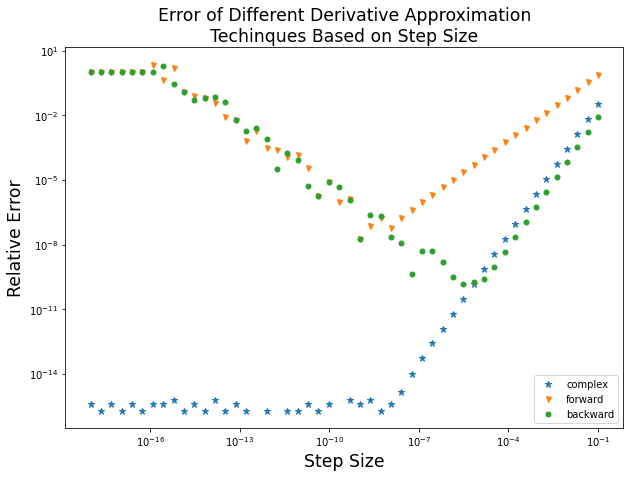

In [5]:
plt.figure(figsize = (10, 7))
plt.plot(step_size, cs_error, '*', ms = 7, label = 'complex')
plt.plot(step_size, fd_error, 'v', ms = 5, label = 'forward')
# plt.plot(step_size, cd_error, 'v', ms = 5, label = 'central')
plt.plot(step_size, bd_error, 'o', ms = 5, label = 'backward')
# plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Step Size', fontsize = 'xx-large')
plt.ylabel('Relative Error', fontsize = 'xx-large')
plt.title('Error of Different Derivative Approximation\nTechinques Based on Step Size', fontsize = 'xx-large')
plt.legend()
plt.savefig('relative_error')
plt.show()

### Implementing the complex step appx. for multivariate functions

In [6]:
### performs the complex step approximation for multivariate functions
# Params:
# func: function to approximate gradient
# x: x value for calculating gradient
# dim: dimensions of domain of f
# step: stepsize
#Returns: Approximation to gradient of func evaluated at x
def multivariate_complex_step(func, x, dim, step = 1e-4):
    xstep = x.astype(complex)
    xstep[dim] += complex(0, step)
    return np.imag(func(xstep)/step)

#### Applying it to gradient descent

In [7]:
### complex_grad_desc - approximates gradient descent using complex step approximation
# Params: 
# func: objective function, what we want to minimize - must be analytic in each dimension
# x0: an initial guess as a numpy array
# stepsize: how much to move guess each iteration
# tol: tolerance on desired solution
# max_iters: maximum number of iterations before termination
# Returns: approximation to argmin of objective function
def complex_grad_desc(func, x0, grad_step = .001, complex_step = 1e-5, tol = 1e-8, max_iters = 1000):
    iterates = [x0]
    dims = len(x0)
    
    for _ in range(max_iters):
        x1 = np.zeros(x0.shape)
        
        #update each dimension
        for d in range(dims):
            grad = multivariate_complex_step(func, x0, d, step = complex_step)
            x1[d] = x0[d] - grad_step * grad
        
        if np.linalg.norm(x0 - x1) < tol:
            return x1, iterates
        
        iterates.append(x1)
        x0 = x1
        
    return x1, iterates

#Normal gradient descent
def grad_desc(func, grad, x0, grad_step = .001, tol = 1e-8, max_iters = 1000):
    iterates = [x0]    
    for _ in range(max_iters):
        grx0 = grad(x0)
        x1 = x0 - grad_step * grx0

        if np.linalg.norm(x0 - x1) < tol:
            return x1, iterates
        
        iterates.append(x1)
        x0 = x1
        
    return x1, iterates

#### Testing the method on a simple convex function, $f(\bar x) = x_1^2 + x_2^2$

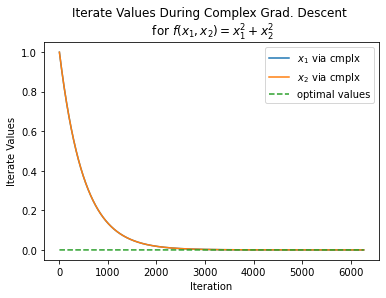

In [9]:
test_func = lambda x: x[0]**2 + x[1]**2
test_grad = lambda x: 2*x[0] + 2*x[1]
x0 = np.array([1,1])
cplx_xstar, cplx_iters = complex_grad_desc(test_func, x0, complex_step = 1e-8, max_iters = 20000)
x1 = [i[0] for i in cplx_iters]
x2 = [i[1] for i in cplx_iters]
true_soln = [0 for i in range(len(x1))]
xvals = [i for i in range(len(cplx_iters))]
plt.plot(xvals, x1, label = '$x_1$ via cmplx')
plt.plot(xvals, x2, label = '$x_2$ via cmplx')
plt.plot(xvals, true_soln, '--', label = 'optimal values')
plt.title('Iterate Values During Complex Grad. Descent \n for $f(x_1, x_2) = x_1^2 + x_2^2$')
plt.ylabel('Iterate Values')
plt.xlabel('Iteration')
plt.legend()
plt.savefig('complex_grad_desc_convex.pdf')

#### Testing performance on non-convex function with ideal start, $f(\bar x) = x_1^2 + x_2^3$

In [10]:
test_func = lambda x: x[0]**2 + x[1]**3 

test_grad = lambda x: 2*x[0] + 3*x[1]**2

In [11]:
x0 = np.array([1,1])
cplx_xstar, cplx_iters = complex_grad_desc(test_func, x0, complex_step = 1e-8, max_iters = 20000)

In [12]:
gd_xstar, gd_iters = grad_desc(test_func, test_grad, x0, max_iters = 10000)

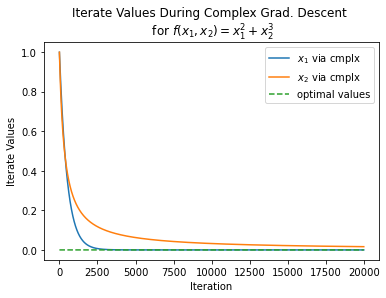

In [13]:
x1 = [i[0] for i in cplx_iters]
x2 = [i[1] for i in cplx_iters]
true_soln = [0 for i in range(len(x1))]
xvals = [i for i in range(len(cplx_iters))]
plt.plot(xvals, x1, label = '$x_1$ via cmplx')
plt.plot(xvals, x2, label = '$x_2$ via cmplx')
plt.plot(xvals, true_soln, '--', label = 'optimal values')
plt.title('Iterate Values During Complex Grad. Descent \n for $f(x_1, x_2) = x_1^2 + x_2^3$')
plt.ylabel('Iterate Values')
plt.xlabel('Iteration')
plt.legend()
plt.savefig('complex_grad_desc_non_convex.pdf')

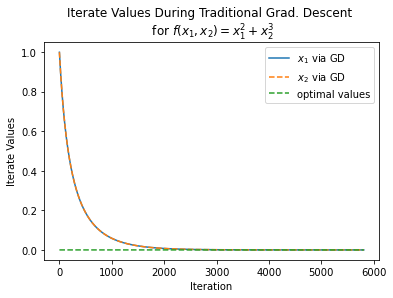

In [14]:
x1 = [i[0] for i in gd_iters]
x2 = [i[1] for i in gd_iters]
true_vals = np.zeros(len(x1))
xvals = [i for i in range(len(gd_iters))]
plt.plot(xvals, x1, label = '$x_1$ via GD')
plt.plot(xvals, x2, '--', label = '$x_2$ via GD')
plt.plot(xvals, true_vals, '--', label = 'optimal values')
plt.title('Iterate Values During Traditional Grad. Descent \n for $f(x_1, x_2) = x_1^2 + x_2^3$')
plt.ylabel('Iterate Values')
plt.xlabel('Iteration')
plt.legend()
plt.savefig('grad_desc.pdf')

### Implementing $n^{th}$ derivative approximation
#### (Theory from Lyness + Moler)

In [15]:
### Riemann sum operator
##Params:
#func: function whose integral is to be approximated
#m: number of trapezoids use in the approximation
#returns: Trapezoidal Riemann sum with m partitions on [0,1]
def trap_sum(func, m):
    t_sum = .5 * func(0) + .5*func(1)
    args = [i/m for i in range(1,m)]
    for arg in args:
        t_sum += func(arg)
    return t_sum / m

In [16]:
## Mobius function code
# CODE FROM https://www.geeksforgeeks.org/program-mobius-function/

#Verifies if a number is prime
def isPrime(n) :
 
    if (n < 2) :
        return False
    for i in range(2, n + 1) :
        if (i * i <= n and n % i == 0) :
            return False
    return True

#returns the Nth mobius number
def mobius(N) :
     
    # Base Case
    if (N == 1) :
        return 1
 
    # For a prime factor i
    # check if i^2 is also
    # a factor.
    p = 0
    for i in range(1, N + 1) :
        if (N % i == 0 and
                isPrime(i)) :
 
            # Check if N is
            # divisible by i^2
            if (N % (i * i) == 0) :
                return 0
            else :
 
                # i occurs only once,
                # increase p
                p = p + 1
 
    # All prime factors are
    # contained only once
    # Return 1 if p is even
    # else -1
    if(p % 2 != 0) :
        return -1
    else :
        return 1

In [17]:
### nth derivative approximation
##params:
#func: function whose derivative is being approximated
#n: order of the derivative to approximate
#r: radius of the circle to use in the complex plane
#sum_terms: number of terms to include while calculating nth derivative
def nthderiv(func, n, r, sum_terms):
    gfunc = lambda t : np.real(func(r * np.exp(complex(0,2 * np.pi * t))))
    origin = func(0)
    total_sum = 0
    for m in range(1, sum_terms + 1):
        total_sum += mobius(m) * (trap_sum(gfunc, m*n) - origin)
    return total_sum * np.math.factorial(n) / r**n
    

#### Testing accuracy of approximation on $f(x) = x^{25} + 4x^{20} - 198x^{13} + 14x^4 - 2x^3$

In [18]:
test_func = lambda x : x**25 + 4*x**20 - 198*x**13+14*x**4 - 2*x**3

In [19]:
radii = np.linspace(.1, 10, 25)
num_terms = [1 + i for i in range(101)]

##### Effect on a varying radius:

In [22]:
true_nth_deriv = np.math.factorial(25)
radius_errors = []
num_terms_errors = []

for r in radii:
    rel_error = np.abs(nthderiv(test_func, 25, r, 15) - true_nth_deriv) / true_nth_deriv
    radius_errors.append(rel_error)    

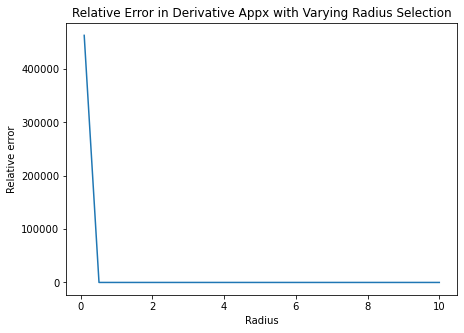

In [23]:
plt.figure(figsize = (7,5))
plt.plot(radii, radius_errors)
plt.title('Relative Error in Derivative Appx with Varying Radius Selection')
plt.ylabel('Relative error')
plt.xlabel('Radius')
plt.savefig('rel_error_full.pdf')

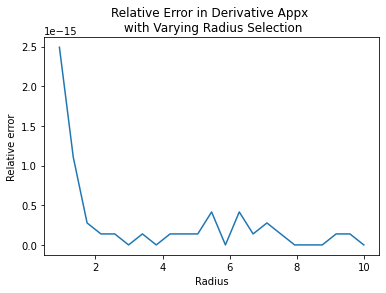

In [24]:
plt.plot(radii[2:], radius_errors[2:])
plt.title('Relative Error in Derivative Appx \n with Varying Radius Selection')
plt.ylabel('Relative error')
plt.xlabel('Radius')
plt.savefig('rel_error_subset.pdf')

##### Effect on including more or fewer terms

In [25]:
true_nth_deriv = np.math.factorial(25)
num_terms_errors = []
for num in num_terms:
    rel_error = np.abs(nthderiv(test_func, 25, 0.5125000000000001, num) - true_nth_deriv) / true_nth_deriv
    num_terms_errors.append(rel_error)

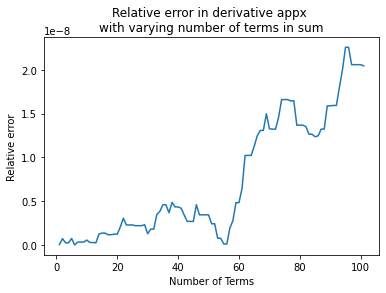

In [26]:
plt.plot(num_terms, num_terms_errors)
plt.title('Relative error in derivative appx \nwith varying number of terms in sum')
plt.ylabel('Relative error')
plt.xlabel('Number of Terms')
plt.savefig('rel_error_num_terms.pdf')

##### Effect on approximating lower vs higher order derivatives

In [27]:
derivs = [3, 4, 13, 20]
deriv_vals = [2 * 6, 14 * 24, 198*np.math.factorial(13), 4*np.math.factorial(20)]
deriv_errors = []

for i in range(4):
    errors = []
    for r in radii:
        rel_error = np.abs(nthderiv(test_func, derivs[i], r, 15) - deriv_vals[i]) / deriv_vals[i]
        errors.append(rel_error)
    deriv_errors.append(errors)

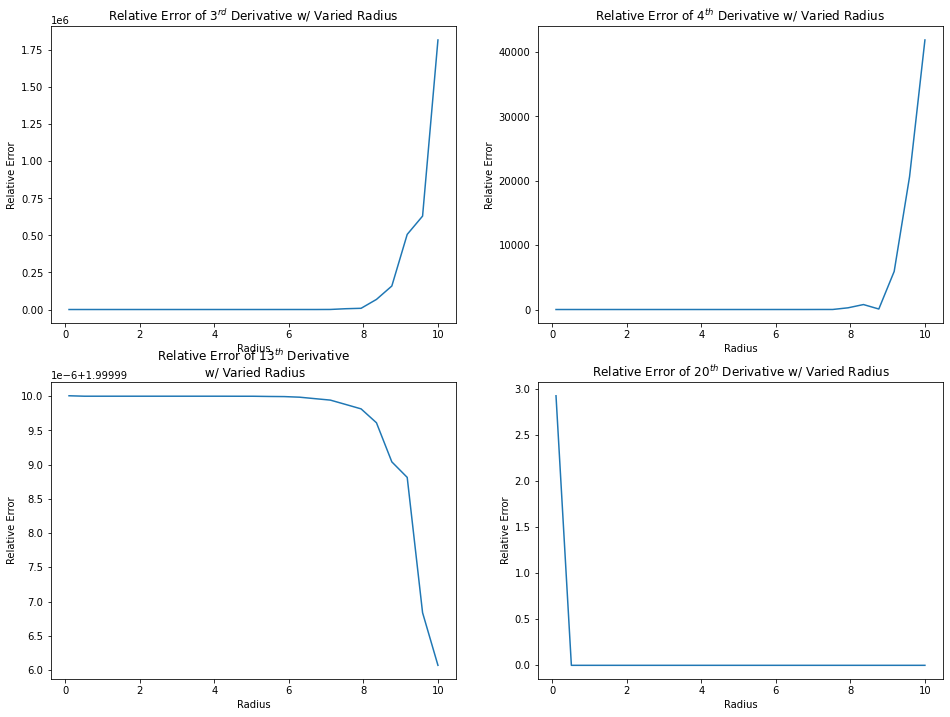

In [28]:
fig, ax = plt.subplots(2,2, figsize = (16, 12))
ax[0][0].plot(radii, deriv_errors[0])
ax[0][0].set_title('Relative Error of 3$^{rd}$ Derivative w/ Varied Radius')
ax[0][0].set_xlabel('Radius')
ax[0][0].set_ylabel('Relative Error')

ax[0][1].plot(radii, deriv_errors[1])
ax[0][1].set_title('Relative Error of 4$^{th}$ Derivative w/ Varied Radius')
ax[0][1].set_xlabel('Radius')
ax[0][1].set_ylabel('Relative Error')

ax[1][0].plot(radii, deriv_errors[2])
ax[1][0].set_title('Relative Error of 13$^{th}$ Derivative \n w/ Varied Radius')
ax[1][0].set_xlabel('Radius')
ax[1][0].set_ylabel('Relative Error')

ax[1][1].plot(radii, deriv_errors[3])
ax[1][1].set_title('Relative Error of 20$^{th}$ Derivative w/ Varied Radius')
ax[1][1].set_xlabel('Radius')
ax[1][1].set_ylabel('Relative Error')

plt.savefig('quad_plot.pdf')